# Analysis plan

* Load training data
* Make sure classes are evenly balanced, otherwise throw exception
* Load validation data
* Train model on training data
* Test model on validation data
* Move uncertain images from training and holdout sets to review folder
* Manually review uncertain images
* Adjust images as needed (delete bad images and move misclassified good images to training set)
* Calculate validation metrics for each occupation
* Create more training data if some occupations have bad metrics
* Repeat as needed
* Run final model against holdout data that hasn't been previously examined
* Calculate overall metrics and break out by gender and occupation
* Run final model against unlabeled data
* Save prediction for each image
* Calculate gender representation for each occupation

In [1]:
import datetime
import os
from typing import Union
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.datasets import ImageFolder

torch.cuda.is_available()

True

In [2]:
# Config variables
train_color = "#ffffb3"
val_color = "#bebada"
data_dir = 'H:/Photos/AI/'
batch_size = 200
classes = ('Female', 'Male')
use_custom_normalization = True

In [3]:
# Helpers
def current_time_only() -> str:
    """Print current time at second precision without date ('%H:%M:%S')."""
    return datetime.datetime.now().strftime('%H:%M:%S')


def count_files_in_directory(path: Union[str, 'LiteralString']) -> int:
    """
    Returns the number of items found in the given folder. Assumes that the path 
    contains no subdirectories and only files.

    Parameters:
    path (str): The file path to the directory whose contents are to be counted.

    Raises:
    FileNotFoundError: If the given path does not exist or is not a directory.

    Returns:
    int: The number of files in the directory.
    """
    return len(os.listdir(path))


def plot_training_progress(train_acc: list, train_loss: list, val_acc: list, val_loss: list, title = "Model results"):
    """
    Plot training-vs-testing accuracy and loss for each epoch.
    
    Parameters:
        train_acc (list): List of training accuracy values from each epoch, must be same length as val_acc
        train_loss (list): List of training loss values from each epoch, must be same length as val_loss
        val_acc (list): List of validation accuracy values from each epoch, must be same length as train_acc
        val_loss (list): List of validation loss values from each epoch, must be same length as train_loss
    
    Raises:
        ValueError: If the lengths of accuracy or loss lists don't match either other
    """
    if not (len(train_acc) == len(val_acc) and len(train_loss) == len(val_loss)):
        raise ValueError("Lengths of training and validation lists must match")
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(train_acc,
                label="Training accuracy",
                color=train_color,
                linewidth=3)
    axs[0].plot(val_acc,
                label="Validation accuracy",
                color=val_color,
                linewidth=3)
    axs[0].set_title("Accuracy")
    axs[0].set(ylim=(0, 100))
    axs[0].legend()

    axs[1].plot(train_loss,
                label="Training loss",
                color=train_color,
                linewidth=3)
    axs[1].plot(val_loss,
                label="Validation loss",
                color=val_color,
                linewidth=3)
    axs[1].set_title("Loss")
    axs[1].set(ylim=(0, None))
    axs[1].legend()

    fig.suptitle(title, fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()


class ImbalancedClassesException(ValueError):
    """Exception raised when classes must be perfectly balanced and are not."""

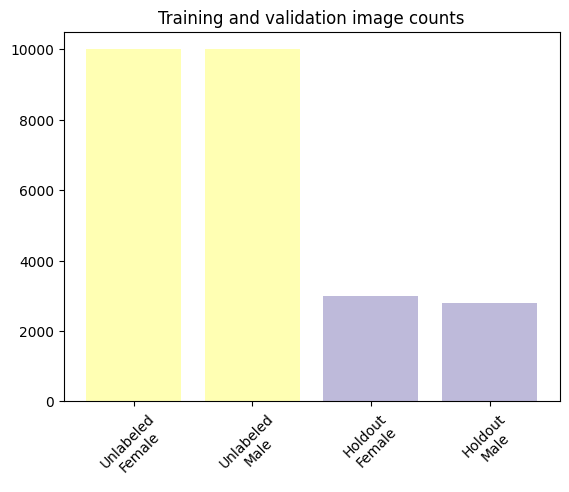

In [4]:
# Count the number of images in each training folder and throw exception if imbalanced
file_counts = {category: {gender: count_files_in_directory(
    os.path.join(data_dir, category, gender))
    for gender in classes}
    for category in ['Labeled', 'Holdout']}

fig, ax = plt.subplots()
ax.bar(['Unlabeled\nFemale', 'Unlabeled\nMale',
        'Holdout\nFemale', 'Holdout\nMale'],
       [file_counts['Labeled']['Female'],
        file_counts['Labeled']['Male'],
        file_counts['Holdout']['Female'],
        file_counts['Holdout']['Male']],
       color=[train_color, train_color, val_color, val_color])
plt.xticks(rotation=45)
plt.title("Training and validation image counts")

if file_counts['Labeled']['Female'] != file_counts['Labeled']['Male']:
    female_count = file_counts['Labeled']['Female']
    male_count = file_counts['Labeled']['Male']
    raise ImbalancedClassesException(
        f'Imbalance detected: {female_count} female images vs {male_count} male images')


In [ ]:
# Calculate the mean and standard deviation of the dataset for normalization.
# These values can be used to replace the hard-coded ImageNet normalization values
# in the next code block for improved performance in certain conditions.
if use_custom_normalization:
    tensor_transform = transforms.Compose([
        transforms.Resize((512, 512)),  # Resize to a fixed size
        transforms.ToTensor()           # Convert images to PyTorch tensors
    ])
    
    # Create a dataset without normalization
    unnormalized_dataset = ImageFolder(os.path.join(data_dir, 'Labeled'), transform=tensor_transform)
    unnormalized_loader = DataLoader(unnormalized_dataset, batch_size=batch_size, shuffle=True)
    
    # Function to calculate mean and std
    def calculate_mean_std(loader: DataLoader) -> (torch.Tensor, torch.Tensor):
        """
        Calculate the mean and standard deviation of images in a DataLoader.
    
        Parameters:
        loader (DataLoader): The DataLoader containing the dataset.
    
        Returns:
        Tuple[torch.Tensor, torch.Tensor]: Mean and standard deviation tensors.
        """
        mean_accumulator = 0.0
        variance_accumulator = 0.0
        for images, _ in loader:
            batch_samples = images.size(0)
            images = images.view(batch_samples, images.size(1), -1)
            mean_accumulator += images.mean(2).sum(0)
            variance_accumulator += images.var(2).sum(0)
    
        mean_accumulator /= len(loader.dataset)
        std_deviation = torch.sqrt(variance_accumulator / len(loader.dataset))
        return mean_accumulator, std_deviation
    
    dataset_mean, dataset_std = calculate_mean_std(unnormalized_loader)
    normalization_values = {'mean': dataset_mean.tolist(), 'std': dataset_std.tolist()}
    del unnormalized_dataset, unnormalized_loader
else:
    normalization_values = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}

print(normalization_values)

In [ ]:
# Load train/test images in Pytorch format
transformations = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to a fixed size
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=normalization_values['mean'], std=normalization_values['std'])
])

train_dataset = ImageFolder(os.path.join(data_dir, 'Labeled'), transform=transformations)
val_dataset = ImageFolder(os.path.join(data_dir, 'Holdout'), transform=transformations)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def display_images_from_dataloader(dataloader: DataLoader, num_images: int = 8):
    """
    Fetches a batch of images from the given DataLoader, and displays a specified number 
    of images from this batch.

    Parameters:
    dataloader (DataLoader): A PyTorch DataLoader object from which to fetch the images.
    num_images (int): The number of images to display from the batch.
    """

    def imshow(img: torch.Tensor):
        """
        Display an image by denormalizing and clipping its values.

        This function takes a PyTorch tensor representing a grid of images, which have been normalized 
        previously, and performs denormalization to convert them back to their original color 
        space. It then clips the image values to be within the range [0, 1] to ensure 
        proper display. The image is displayed using matplotlib.

        Parameters:
        img (torch.Tensor): A PyTorch tensor representing a grid of images.
        """
        img = img.numpy().transpose((1, 2, 0))
        img = normalization_values['std'] * img + normalization_values['mean']  # Denormalize
        img = np.clip(img, 0, 1)  # Clip values to be between 0 and 1
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.show()

    num_images = min(batch_size, num_images)
    dataset_images, dataset_labels = next(iter(dataloader))
    images_subset = dataset_images[:num_images]
    imshow(torchvision.utils.make_grid(images_subset))
    print(' '.join(f'{classes[dataset_labels[j]]:5s}' for j in range(num_images)))

display_images_from_dataloader(train_loader, num_images=16)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 125 * 125, 120)  # Corrected size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)  # For binary classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
train_epoch_loss = []
train_epoch_accuracy = []
validation_epoch_loss = []
validation_epoch_accuracy = []

for epoch in range(18):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader, 0):
        if i % 250 == 0:
            print(f"Loading batch {i}/{len(train_loader)} ({datetime.datetime.now().strftime('%H:%M:%S')})")
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print training loss and accuracy
    print(f'Epoch {epoch + 1}, Training loss: {running_loss / len(train_loader):.3f}')
    print(f'Epoch {epoch + 1}, Training accuracy: {100 * correct / total:.2f}%')
    train_epoch_loss.append(running_loss / len(train_loader))
    train_epoch_accuracy.append(100 * correct / total)

    # Validation loss and accuracy
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            if i % 250 == 0:
                print(f"Validating batch {i+1}/{len(val_loader)} ({current_time_only()})")
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Epoch {epoch + 1}, validation loss: {val_loss / len(val_loader):.3f}')
    print(f'Epoch {epoch + 1},  validation accuracy: {100 * correct / total:.2f}%')
    validation_epoch_loss.append(val_loss / len(val_loader))
    validation_epoch_accuracy.append(100 * correct / total)

print(f"Finished Training at {current_time_only()}")

Loading batch 0/500 (19:54:53)
Loading batch 250/500 (20:00:50)
Epoch 1, Training loss: 0.672
Epoch 1, Training accuracy: 57.92%
Validating batch 1/145 (20:06:24)
Validation loss: 0.637
Validation accuracy: 63.34%
Loading batch 0/500 (20:07:55)
Loading batch 250/500 (20:13:47)
Epoch 2, Training loss: 0.625
Epoch 2, Training accuracy: 64.65%
Validating batch 1/145 (20:19:39)
Validation loss: 0.584
Validation accuracy: 69.38%
Loading batch 0/500 (20:21:17)
Loading batch 250/500 (20:27:14)
Epoch 3, Training loss: 0.561
Epoch 3, Training accuracy: 70.28%
Validating batch 1/145 (20:32:36)
Validation loss: 0.549
Validation accuracy: 71.59%
Loading batch 0/500 (20:34:05)
Loading batch 250/500 (20:39:39)
Epoch 4, Training loss: 0.500
Epoch 4, Training accuracy: 75.25%
Validating batch 1/145 (20:45:08)
Validation loss: 0.512
Validation accuracy: 74.56%
Loading batch 0/500 (20:46:36)
Loading batch 250/500 (20:52:00)
Epoch 5, Training loss: 0.425
Epoch 5, Training accuracy: 80.05%
Validating batc

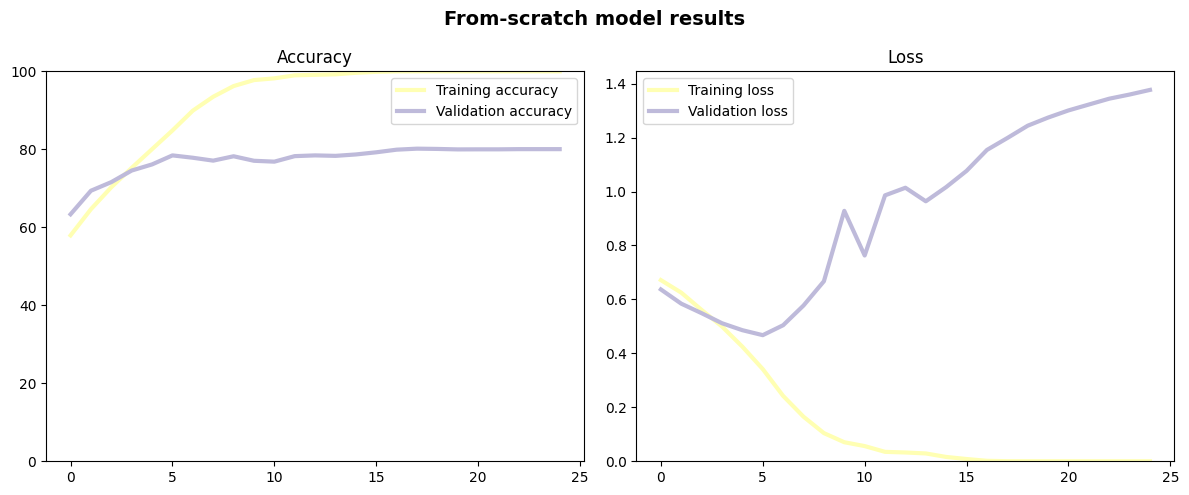

In [30]:
plot_training_progress(train_acc=train_epoch_accuracy,
                       train_loss=train_epoch_loss,
                       val_acc=validation_epoch_accuracy,
                       val_loss=validation_epoch_loss,
                       title = "From-scratch model results")

In [8]:
# This code is currently redundant with the last CV update in the training loop, but I have plans
# TODO: Save the predicted probability for each training image
# TODO: Save the predicted probability for each validation image
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for i, data in enumerate(val_loader, 0):
        if i % 150 == 0:
            print(f"Validating batch {i+1}/{len(val_loader)} ({current_time_only()})")
        images, labels = data
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Validation loss: {val_loss / len(val_loader):.3f}')
print(f'Validation accuracy: {100 * correct / total:.2f}%')

# TODO: Analyze CV prediction accuracy by gender and occupation
# TODO: Move low-certainty images and high-certainty misses to a folder for human review

Validating batch 1/145 (01:03:16)
Validation loss: 1.377
Validation accuracy: 80.05%


In [9]:
# TODO: Automatically save model with timestamp in filename
torch.save(net.state_dict(), "pytorch_model_overfit.pth")

# Pre-trained model

In [ ]:
# Load a pre-trained ResNet model
model_resnet = models.resnet50(pretrained=True)

# Freeze the layers except the final layer
for param in model_resnet.parameters():
    param.requires_grad = False

# Replace the last fully connected layer
num_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_features, 2)  # For binary classification

# Move model_resnet to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimize the parameters of the final layer
optimizer = optim.Adam(model_resnet.fc.parameters(), lr=0.001)

In [ ]:
resnet_train_epoch_loss = []
resnet_train_epoch_accuracy = []
resnet_validation_epoch_loss = []
resnet_validation_epoch_accuracy = []

# Fine-tune the ResNet model
num_epochs = 6 
for epoch in range(num_epochs):
    model_resnet.train()
    print(f"Epoch {epoch+1} initiated ({current_time_only()})")
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        if i % 250 == 0:
            print(f"Training batch {i+1}/{len(train_loader)} ({current_time_only()})")
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    resnet_train_epoch_loss.append(running_loss / len(train_loader))
    resnet_train_epoch_accuracy.append(correct_train / total_train)

    # Validation
    model_resnet.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        print(f"Validation started ({current_time_only()})")
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_resnet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and store the validation loss and accuracy for the epoch
    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_accuracy = correct / total
    resnet_validation_epoch_loss.append(epoch_val_loss)
    resnet_validation_epoch_accuracy.append(epoch_val_accuracy)

    print("\n\n" + "*" * 50)
    print(f"{'*' * 10} EPOCH RESULTS {'*' * 10}".center(50))
    print("*" * 50)
    print(f'\033[1mEpoch {epoch+1}/{num_epochs}\033[0m, '
          f'\033[94mTrain Loss: {running_loss/len(train_loader):.3f}\033[0m, '
          f'\033[92mValidation Loss: {epoch_val_loss:.3f}\033[0m, '
          f'\033[93mTraining Accuracy: {100 * correct_train / total_train:.2f}%\033[0m, '
          f'\033[91mValidation Accuracy: {100 * epoch_val_accuracy:.2f}%\033[0m')
    print("*" * 50 + "\n\n")

print(f'Finished Training ({current_time_only()})')

In [ ]:
# model_resnet.eval()
# val_loss = 0.0
# correct = 0
# total = 0
# with torch.no_grad():
#     print(f"Validation started ({current_time_only()})")
#     for inputs, labels in val_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model_resnet(inputs)
#         loss = criterion(outputs, labels)
#         val_loss += loss.item()
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
# 
# print(f'Epoch {epoch+1}/{num_epochs}, '
#       f'Train Loss: {running_loss/len(train_loader):.3f}, '
#       f'Validation Loss: {val_loss/len(val_loader):.3f}, '
#       f'Validation Accuracy: {100 * correct / total:.2f}%')

In [ ]:
plot_training_progress(train_acc=resnet_train_epoch_accuracy,
                       train_loss=resnet_train_epoch_loss,
                       val_acc=resnet_validation_epoch_accuracy,
                       val_loss=resnet_validation_epoch_loss,
                       title = "Fine-tuned model results")